In [66]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Jun  4 14:06:46 2024

@author: peter
"""

import matplotlib.pylab as plt
import ruptures as rpt
import numpy as np
from geneticalgorithm import geneticalgorithm as ga

# simple to use
# https://pypi.org/project/geneticalgorithm/   

#
# https://pypi.org/project/geneticalgorithm2/    

# see also pyGAD, complex with many features
# https://pypi.org/project/pygad/   
# https://pygad.readthedocs.io
# https://github.com/ahmedfgad/GeneticAlgorithmPython

In [67]:
# set simulation parameters
#
my_rand_seed = 12345

margin=10   # margin of error for false discovery rate (fdr): FP/(TP+FP)
            # when detection is too late, e.g. > 10ms after true onset time

num_signals = 100  # number of trials in simulation, GA is slow, use only 100 for a quick sim. If more time, try 1000.

mu, sigma = 1, 1 # mean and standard deviation for simulated data generation
mu2, sigma2 = mu + 1, sigma + 1
n_bkps=1
true_onset=200

times = np.arange(0, 451, 1).tolist()

### 10 cost functions
<pre>
https://centre-borelli.github.io/ruptures-docs/code-reference/ more current

https://dev.ipol.im/~truong/ruptures-docs/build/html/costs/index.html

l1: absolute deviation from the mean

l2: squared deviation from the mean

normal: Gaussian process change: detects changes in the mean and scale of a
        Gaussian time series.

rbf: Kernelized mean change: the kernel is the radial basis function (rbf).

cosine: Kernel change point detection with the cosine similarity.

linear: Linear model change: The least-squares estimates of the break dates
         is obtained by minimiming the sum of squared residuals.

clinear: cost linear: Least-square estimate for linear changes.

rank: detects general distribution changes in multivariate signals,
       using a rank transformation

mahalanobis: detects changes in the mean of the embedded
             signal defined by the pseudo-metric

ar: Autoregressive model change: The least-squares estimates of the break
    dates is obtained by minimiming the sum of squared residuals.
    default: order=4
    or use params={"order": 10} to change the order
    [ y[t−1], y[t−2],…,y[t−p] ] is the lag vector, and p>0
                                is the order of the process.
</pre>

### Helper functions

In [68]:
# Note: linear cost function require > 1 dimensions.
#
mdl_list =['l1', 'l2', 'normal', 'rbf', 'cosine', 'linear', 'clinear', \
           'rank', 'mahalanobis', 'ar']


def make_data(mu, sigma, mu2, sigma2, true_onset, rng):
    s1 = rng.normal(mu, sigma, true_onset-1)
    s2 = rng.normal(mu2, sigma2, 251)
    signal= np.array(list(s1) + list(s2))
    return signal


def get_MAE(predictions, true_onset):
    MAE = np.mean(np.abs(predictions - true_onset))
    return MAE


def report_performance(prediction_lists, mdl_list, algo_name):
    print(algo_name)
    min_idx=0
    min_MAE=1000000
    pred_mae_list=[]
    for ii, preds in enumerate(prediction_lists):
        mdl = mdl_list[ii]
        preds = np.array(preds)
        MAE = get_MAE(preds, true_onset);
        pred_mae_list.append(MAE)
        if MAE < min_MAE:
            min_MAE = MAE
            min_idx=ii
        print("MAE: %6.2f, cost function = %s" % (MAE, mdl)  )
        #var = get_variance(preds, true_onset)
        #bias = get_bias(preds, true_onset)
        #fdr = get_fdr(preds, true_onset, margin)
        #print("%11s %11s: MAE = %6.2f ms, var=%8.2f, bias=%6.2f, fdr=%6.2f" % (algo_name, mdl, MAE, var, bias, fdr))
    print("Lowest MAE: %6.2f, cost function = %s" % (min_MAE, mdl_list[min_idx] )  )
    return pred_mae_list

### Example signal and true onset time

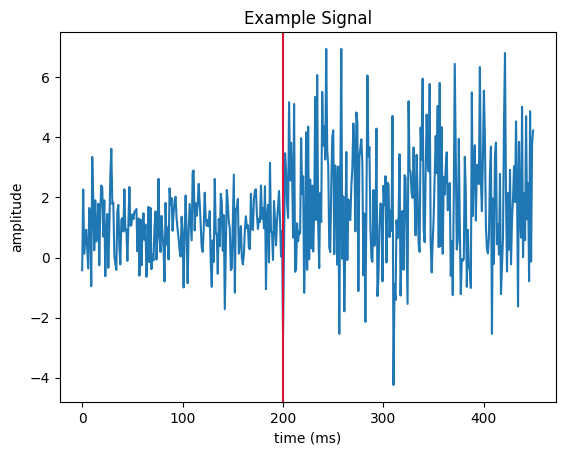

In [69]:
rng=np.random.default_rng(my_rand_seed) 

# generate signal
signal = make_data(mu, sigma, mu2, sigma2, true_onset, rng)

plt.plot(signal)
plt.title("Example Signal")
plt.ylabel("amplitude")
plt.xlabel("time (ms)")
plt.axvline(200, c="crimson", label="real onset");

In [70]:
def run_binseg_sim():
    binseg_list = []

    for mdl in mdl_list:
        binseg_predictions = []
        rng=np.random.default_rng(my_rand_seed) # reset rng for each model

        for ii in range(num_signals):
            # generate signal
            signal = make_data(mu, sigma, mu2, sigma2, true_onset, rng)

            # linear requires > 1 dimensions
            if mdl=="linear":
                n=len(signal)
                tt = np.linspace(0, 10*np.pi, n)
                X = np.vstack((np.sin(tt), np.sin(5*tt), np.ones(n))).T
                signal = np.column_stack((signal.reshape(-1, 1), X))

            # Binseg algorithm
            algo = rpt.Binseg(model=mdl, custom_cost=None, min_size=2, jump=5, params=None).fit(signal)
            est_onset = algo.predict(n_bkps=n_bkps, pen=None, epsilon=None)
            binseg_predictions.append(est_onset[0])
        binseg_list.append(binseg_predictions)
    return binseg_list

In [71]:
binseg_list = run_binseg_sim()

algo_name="BinSeg"
binseg_mae_list=report_performance(binseg_list, mdl_list, algo_name)

BinSeg
MAE:  12.25, cost function = l1
MAE:  10.95, cost function = l2
MAE:   2.75, cost function = normal
MAE:   4.00, cost function = rbf
MAE: 134.15, cost function = cosine
MAE:  13.60, cost function = linear
MAE: 192.15, cost function = clinear
MAE:   9.05, cost function = rank
MAE:  10.95, cost function = mahalanobis
MAE:  20.85, cost function = ar
Lowest MAE:   2.75, cost function = normal


In [72]:
def run_binseg_GA_sim(mdl_num, min_size, jump):

    mdl = mdl_list[mdl_num]

    binseg_list = []
    binseg_predictions = []
    rng=np.random.default_rng(my_rand_seed) # rest rng for each model

    for ii in range(num_signals):
        # generate signal
        signal = make_data(mu, sigma, mu2, sigma2, true_onset, rng)
        
        # linear requires > 1 dimensions
        if mdl=="linear":
            n=len(signal)
            tt = np.linspace(0, 10*np.pi, n)
            X = np.vstack((np.sin(tt), np.sin(5*tt), np.ones(n))).T
            signal = np.column_stack((signal.reshape(-1, 1), X))
                
        ### predict onset
        # Binseg algorithm
        algo = rpt.Binseg(model=mdl, custom_cost=None, min_size=min_size, jump=jump, params=None).fit(signal)
        est_onset = algo.predict(n_bkps=n_bkps)
        binseg_predictions.append(est_onset[0])
    binseg_list.append(binseg_predictions)

    return binseg_list

### genetic algorithm
https://github.com/rmsolgi/geneticalgorithm<br>
<br>
find a near optimal set of parameters for this algorithm and dataset.

 The best solution found:                                                                           
 [2. 2. 1.]

 Objective function:
 2.08


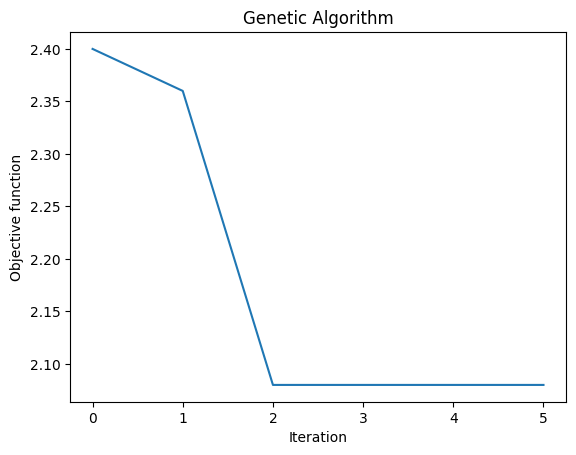

cost function=normal       min_size=2, jump=1


In [76]:
# get mean absolute error, used by GA
#
def get_MAE_GA_1(predictions):
    MAE = np.mean(np.abs(predictions - 200))
    return MAE

# f: fitness function
#
def f(params):
    #print(params)
    mdl_num  = int(params[0])
    min_size = int(params[1])
    jump     = int(params[2])
    predictions = run_binseg_GA_sim(mdl_num, min_size, jump)
    predictions = np.array(predictions)
    return get_MAE_GA_1(predictions)

# set some paramters with a short running time as a demo
max_it=5
pop_size=10
vartype='int'
# want to pick a cost function index, and min segment size, and jump size 
# with a range of integers, e.g. 1..5
varbound=np.array([[0,8], [1,5], [1,5] ])

# defaults: 
'''algorithm_param = {'max_num_iteration': None,    'population_size':100,\
                      'mutation_probability':0.1,   'elit_ratio': 0.01,\ 
                      'crossover_probability': 0.5, 'parents_portion': 0.3,\
                      'crossover_type':'uniform',   'max_iteration_without_improv':None}
'''

algorithm_param = {'max_num_iteration': max_it,  'population_size':pop_size,\
                   'mutation_probability':0.4,   'elit_ratio': 0.01,\
                   'crossover_probability': 0.3, 'parents_portion': 0.3,\
                   'crossover_type':'uniform',   'max_iteration_without_improv':5}

model=ga(function=f, dimension=3, variable_type=vartype,
         variable_boundaries=varbound, algorithm_parameters=algorithm_param,
         convergence_curve=True,\
         progress_bar=True)

model.run()
#convergence=model.report
#print("convergence: ", convergence)
solution=model.best_variable
cost_f = mdl_list[ int(solution[0]) ]
min_size = solution[1]
jump=solution[2]
print("cost function=%-12s min_size=%d, jump=%d" % (cost_f, min_size, jump))